In [2]:
%matplotlib inline
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.6 MB/s eta 0:00:00



# Bayesian optimization with `skopt`

Gilles Louppe, Manoj Kumar July 2016.
Reformatted by Holger Nahrstaedt 2020

.. currentmodule:: skopt

## Problem statement

We are interested in solving

\begin{align}x^* = arg \min_x f(x)\end{align}

under the constraints that

- $f$ is a black box for which no closed form is known
  (nor its gradients);
- $f$ is expensive to evaluate;
- and evaluations of $y = f(x)$ may be noisy.

**Disclaimer.** If you do not have these constraints, then there
is certainly a better optimization algorithm than Bayesian optimization.

This example uses :class:`plots.plot_gaussian_process` which is available
since version 0.8.

## Bayesian optimization loop

For $t=1:T$:

1. Given observations $(x_i, y_i=f(x_i))$ for $i=1:t$, build a
   probabilistic model for the objective $f$. Integrate out all
   possible true functions, using Gaussian process regression.

2. optimize a cheap acquisition/utility function $u$ based on the
   posterior distribution for sampling the next point.
   $x_{t+1} = arg \min_x u(x)$
   Exploit uncertainty to balance exploration against exploitation.

3. Sample the next observation $y_{t+1}$ at $x_{t+1}$.


## Acquisition functions

Acquisition functions $u(x)$ specify which sample $x$: should be
tried next:

- Expected improvement (default):
  $-EI(x) = -\mathbb{E} [f(x) - f(x_t^+)]$
- Lower confidence bound: $LCB(x) = \mu_{GP}(x) + \kappa \sigma_{GP}(x)$
- Probability of improvement: $-PI(x) = -P(f(x) \geq f(x_t^+) + \kappa)$

where $x_t^+$ is the best point observed so far.

In most cases, acquisition functions provide knobs (e.g., $\kappa$) for
controlling the exploration-exploitation trade-off.
- Search in regions where $\mu_{GP}(x)$ is high (exploitation)
- Probe regions where uncertainty $\sigma_{GP}(x)$ is high (exploration)


In [3]:
print(__doc__)

import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process

Automatically created module for IPython interactive environment


## Toy example

Let assume the following noisy function $f$:



In [4]:
noise_level = 0.1

def f(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))\
           + np.random.randn() * noise_level

**Note.** In `skopt`, functions $f$ are assumed to take as input a 1D
vector $x$: represented as an array-like and to return a scalar
$f(x)$:.



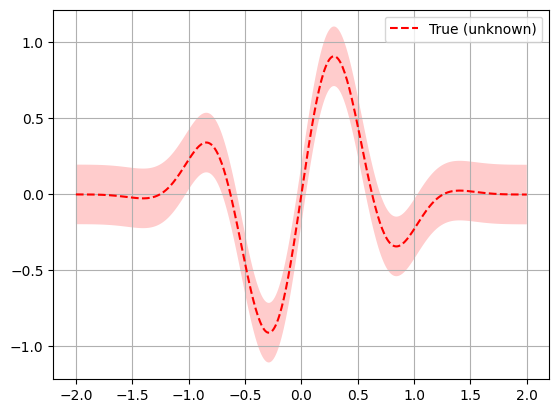

In [5]:
# Plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level=0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx],
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
         alpha=.2, fc="r", ec="None")
plt.legend()
plt.grid()
plt.show()

Bayesian optimization based on gaussian process regression is implemented in
:class:`gp_minimize` and can be carried out as follows:



In [6]:
from skopt import gp_minimize

res = gp_minimize(f,                  # the function to minimize
                  [(-2.0, 2.0)],      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=15,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=0.1**2,       # the noise level (optional)
                  random_state=1234)   # the random seed

Accordingly, the approximated minimum is found to be:



In [7]:
"x^*=%.4f, f(x^*)=%.4f" % (res.x[0], res.fun)

'x^*=-0.3552, f(x^*)=-1.0079'

For further inspection of the results, attributes of the `res` named tuple
provide the following information:

- `x` [float]: location of the minimum.
- `fun` [float]: function value at the minimum.
- `models`: surrogate models used for each iteration.
- `x_iters` [array]:
  location of function evaluation for each iteration.
- `func_vals` [array]: function value for each iteration.
- `space` [Space]: the optimization space.
- `specs` [dict]: parameters passed to the function.



In [8]:
print(res)

          fun: -1.0079192739252805
            x: [-0.355184142786249]
    func_vals: [ 3.716e-02  6.739e-03 ...  8.157e-03 -7.976e-01]
      x_iters: [[-0.009345334109402526], [1.2713537644662787], [0.4484475787090836], [1.0854396754496047], [1.4426790855107496], [0.957924846874036], [-0.4515808656843847], [-0.6859481178696925], [-0.355184142786249], [-0.2931537772945012], [-0.3209941516716812], [-2.0], [2.0], [-1.3373742108323974], [-0.2478422849815407]]
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                                        n_restarts_optimizer=2, noise=0.010000000000000002,
                                        normalize_y=True, random_state=822569775), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                                        n_restarts_optimizer=2, noise=0.010000000000000002,
                                        normalize_

Together these attributes can be used to visually inspect the results of the
minimization, such as the convergence trace or the acquisition function at
the last iteration:



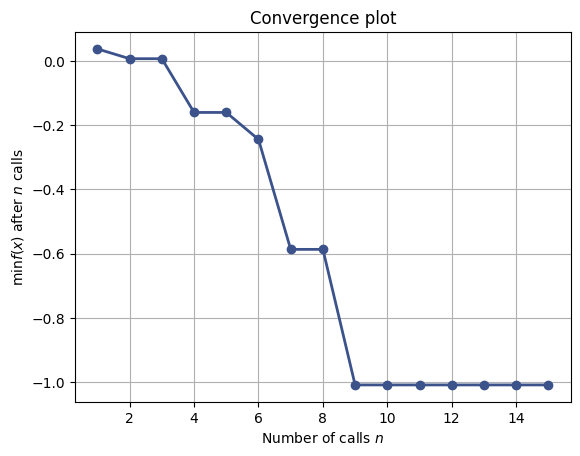

In [9]:
from skopt.plots import plot_convergence
plot_convergence(res);